# Flu Shot Learning: Predicting H1N1 and Seasonal Flu Vaccines

## Importing requirements

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Encoding
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

#Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

#Visualisations
from pandas_profiling import ProfileReport
import missingno as mno

#Models
from sklearn.multioutput import MultiOutputClassifier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.adapt import MLkNN
import xgboost as xgb
from sklearn.multioutput import ClassifierChain
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

#Parameter Search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Metrics
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


## Loading data

In [304]:
#Loading the dataset containing trainining features
features = pd.read_csv("training_set_features.csv", index_col="respondent_id")

#Loading the dataset containing the labels
labels = pd.read_csv("training_set_labels.csv", index_col="respondent_id")

## Exploration

In [305]:
features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [306]:
labels.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


The dataset used consists of 26,707 responses and 38 feature, two of which are our labels/targets

In [307]:
features.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [308]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

We can see the data types available for this dataset are 25 instances of floats, 1 integer and 12 objects.

In [309]:
features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
h1n1_concern,26615.0,1.618486,0.910311,0.0,1.0,2.0,2.0,3.0
h1n1_knowledge,26591.0,1.262532,0.618149,0.0,1.0,1.0,2.0,2.0
behavioral_antiviral_meds,26636.0,0.048844,0.215545,0.0,0.0,0.0,0.0,1.0
behavioral_avoidance,26499.0,0.725612,0.446214,0.0,0.0,1.0,1.0,1.0
behavioral_face_mask,26688.0,0.068982,0.253429,0.0,0.0,0.0,0.0,1.0
behavioral_wash_hands,26665.0,0.825614,0.379448,0.0,1.0,1.0,1.0,1.0
behavioral_large_gatherings,26620.0,0.358640,0.479610,0.0,0.0,0.0,1.0,1.0
behavioral_outside_home,26625.0,0.337315,0.472802,0.0,0.0,0.0,1.0,1.0
behavioral_touch_face,26579.0,0.677264,0.467531,0.0,0.0,1.0,1.0,1.0
doctor_recc_h1n1,24547.0,0.220312,0.414466,0.0,0.0,0.0,0.0,1.0


In [310]:
data_profile = pd.concat([features, labels])

In [311]:
profile = ProfileReport(data_profile, title="H1N1 and Seasonal Flu Vaccines")

In [312]:
#profile

In [313]:
features['behavioral_wash_hands'].value_counts()

1.0    22015
0.0     4650
Name: behavioral_wash_hands, dtype: int64

## Pre-Processing

### Duplicates

In [314]:
#Checking for duplicates
features.duplicated().sum()

0

There are no duplicates in this dataset

### Missing Data

<AxesSubplot: >

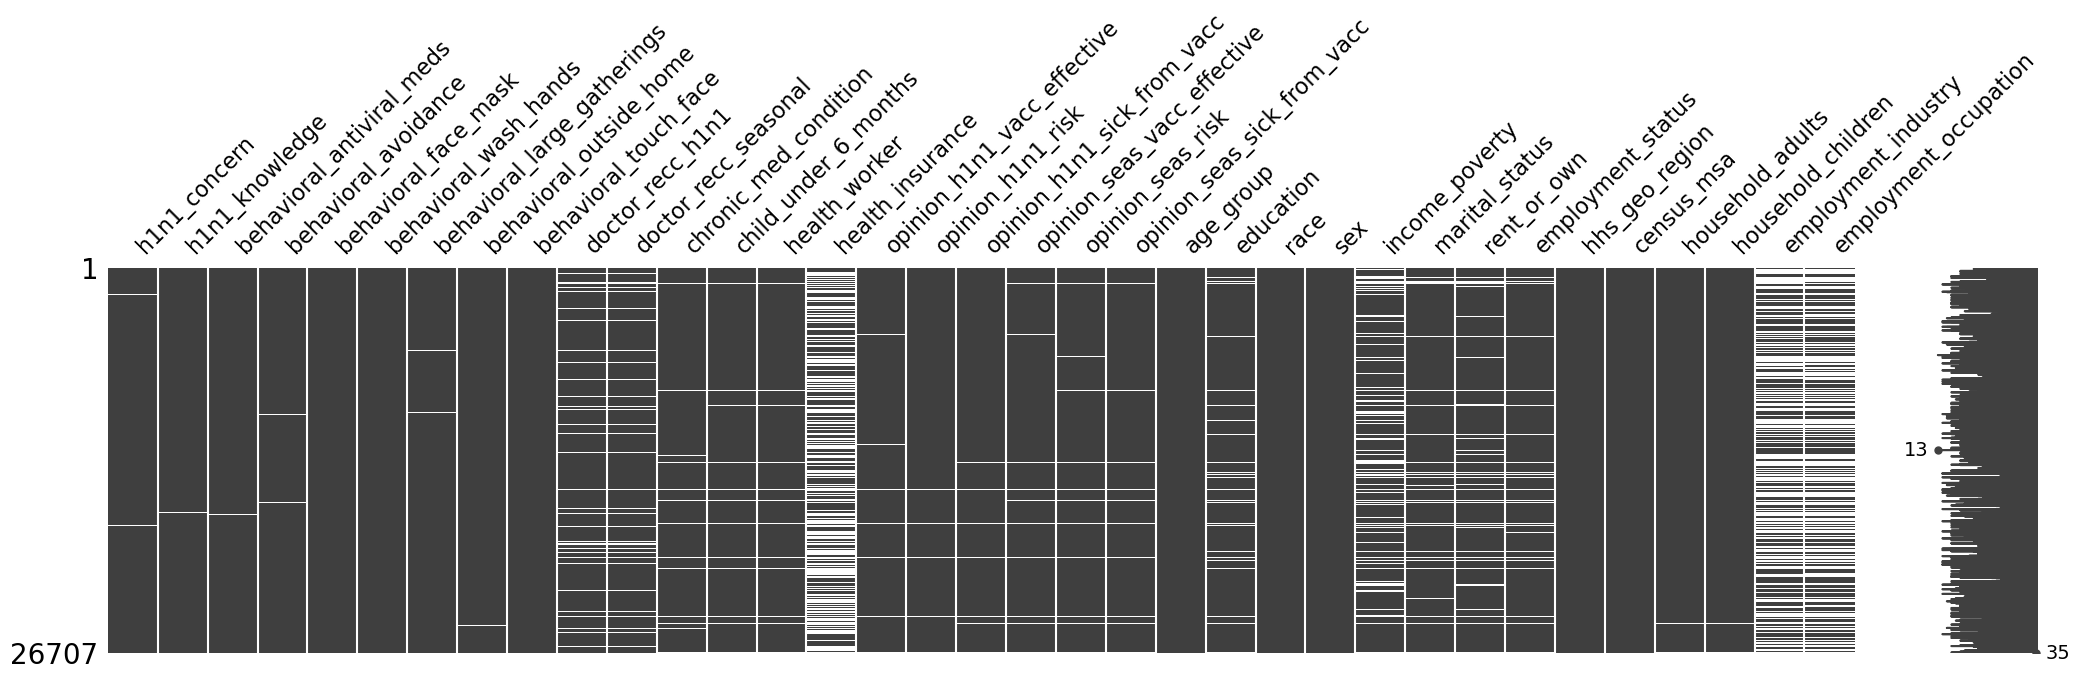

In [315]:
mno.matrix(features, figsize = (25, 5))

In [319]:
missing_data = features.isnull().sum()/len(features)*100
missing_data.sort_values(ascending=False)

income_poverty                 16.561201
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
rent_or_own                     7.645936
employment_status               5.477965
marital_status                  5.272026
education                       5.268282
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
opinion_seas_sick_from_vacc     2.010709
opinion_seas_risk               1.924589
opinion_seas_vacc_effective     1.729884
opinion_h1n1_sick_from_vacc     1.479013
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
household_adults                0.932340
household_children              0.932340
behavioral_avoidance            0.778822
behavioral_touch_face           0.479275
h1n1_knowledge                  0.434343
h1n1_concern                    0.344479
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_antiv

We can see that the following features have over 40% of missing data so we drop them:
- employment_occupation
- employment_industry
- health_insurance

In [317]:
features.drop(["health_insurance", "employment_industry", "employment_occupation"], axis = 1, inplace = True)
features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0


### Imputation of the missing data

In [318]:
features.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty                  object
marital_status           

In [322]:
#Assigning the numerical data to a variable
numeric = features.select_dtypes(exclude="object").columns

In [262]:

##Imputation of the Numerical Data using median
for column in numeric:
    features[column].fillna(features[column].median(), inplace= True)

'\n##Imputation of the Numerical Data using median\nimputer = KNNImputer(n_neighbors=5)\nfor column in numeric_data:\n    features[column].fillna(features[column].median(), inplace= True)\n'

In [323]:
#In order to use the KNN imputer, the data should be normalised to avoid biased replacements
#This is due to the KNN imputation being distance-based
scaler = MinMaxScaler()
numeric_data = pd.DataFrame(scaler.fit_transform(numeric), columns = numeric.columns)
numeric_data.head()

ValueError: could not convert string to float: 'h1n1_concern'

In [324]:
##Imputation of the Numerical Data using KNN
knn_imputer = KNNImputer(n_neighbors=5)

for column in numeric:
    features[column];knn_imputer.fit_transform(numeric_data)

In [325]:
features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0


In [326]:
missing_data.sort_values(ascending=False)

income_poverty                 16.561201
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
rent_or_own                     7.645936
employment_status               5.477965
marital_status                  5.272026
education                       5.268282
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
opinion_seas_sick_from_vacc     2.010709
opinion_seas_risk               1.924589
opinion_seas_vacc_effective     1.729884
opinion_h1n1_sick_from_vacc     1.479013
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
household_adults                0.932340
household_children              0.932340
behavioral_avoidance            0.778822
behavioral_touch_face           0.479275
h1n1_knowledge                  0.434343
h1n1_concern                    0.344479
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_antiv

We've now replaced the numerical data missing data with the means of the K-nearest Neighbor values

#### Encoding

In [335]:
#Assigning nominal data to a list
nominals = [col for col in features.columns if features[col].nunique() == 2] + [
        'race', 'employment_status', 'hhs_geo_region', 'census_msa']

#Assigning ordinal data to a list
ordinals = [col for col in features.columns if col not in nominals]

In [336]:
print(ordinals)

['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty', 'household_adults', 'household_children']


In [302]:
for column in nominals:
    features[column];OneHotEncoder().fit_transform(nominals)

TypeError: TransformerMixin.fit_transform() missing 1 required positional argument: 'X'

In [266]:
for column in ordinals:
    features[column];OrdinalEncoder().fit_transform(ordinals)

In [337]:
col_transformer = make_column_transformer(
    (OneHotEncoder(), nominals),
    (make_pipeline(OrdinalEncoder(), StandardScaler(), SimpleImputer(strategy='most_frequent', add_indicator=True)), ordinals))
col_transformer

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 ['behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1',
                                  'doctor_recc_seasonal',
                                  'chronic_med_condition',
                                  'child_under_6_months', 'health_worker',
                                  '...
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'opinion_h1n1_vacc_effective',
                                  'opinion_h1n1_risk',
                                  'opinion_h1n1_sick_from_vacc',
                                  'opinion_seas_vacc_effective',
                                  'opinion_seas_risk',
                                  'opinion_seas_sick_from_vacc', 'age_group',
                                  'education', 'income_poverty',
                                  'household_adults', 'household_children'])])

In [338]:
features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0


In [339]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.3, random_state=123)

## Random Forest

In [340]:
chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif), RandomForestClassifier()))

forest_pipe = make_pipeline(col_transformer, chain)

In [341]:
# Find best parameters for the model
params = {
    'classifierchain__base_estimator__selectpercentile__percentile': [10, 20, 50],
    'classifierchain__base_estimator__randomforestclassifier__n_estimators': list(range(100, 600, 100)),
    'classifierchain__base_estimator__randomforestclassifier__criterion': ['gini', 'entropy'],
    'classifierchain__base_estimator__randomforestclassifier__max_depth': list(range(5, 16)),
    'classifierchain__base_estimator__randomforestclassifier__bootstrap': [True, False],
    'classifierchain__order': [[0, 1], [1, 0]]
}

forest_grid = RandomizedSearchCV(forest_pipe, params, scoring='roc_auc', n_iter=150, verbose=1, n_jobs=4)

X_train_gr = X_train.sample(frac=0.1)
Y_train_gr = Y_train.loc[X_train_gr.index]

forest_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_touch_face',
                                                                                'doctor_recc_h1n1',
                                                                                'doctor_recc_seasonal...
                                        'classifierchain__base_estimator__randomforestclassifier__criterion': ['gini',
                                                                                                               'entropy'],
                                        'classifierchain__base_estimator__randomforestclassifier__max_depth': [5,
                                                                                                               6,
                                                                                                               7,
                                                                                                               8,
                                                                                                               9,
                                                                                                               10,
                                                                                                               11,
                                                                                                               12,
                                                                                                               13,
                                                                                                               14,
                                                                                                               15],
                                        'classifierchain__base_estimator__randomforestclassifier__n_estimators': [100,
                                                                                                                  200,
                                                                                                                  300,
                                                                                                                  400,
                                                                                                                  500],
                                        'classifierchain__base_estimator__selectpercentile__percentile': [10,
                                                                                                          20,
                                                                                                          50],
                                        'classifierchain__order': [[0, 1],
                                                                   [1, 0]]},
                   scoring='roc_auc', verbose=1)

In [342]:
# Best parameters for the model
display(forest_grid.best_params_)

{'classifierchain__order': [0, 1],
 'classifierchain__base_estimator__selectpercentile__percentile': 50,
 'classifierchain__base_estimator__randomforestclassifier__n_estimators': 200,
 'classifierchain__base_estimator__randomforestclassifier__max_depth': 11,
 'classifierchain__base_estimator__randomforestclassifier__criterion': 'entropy',
 'classifierchain__base_estimator__randomforestclassifier__bootstrap': True}

In [343]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(forest_grid.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(forest_grid.score(X_test, Y_test)))

Best model in-sample score: 0.9109
Best model out-of-sample score: 0.8386


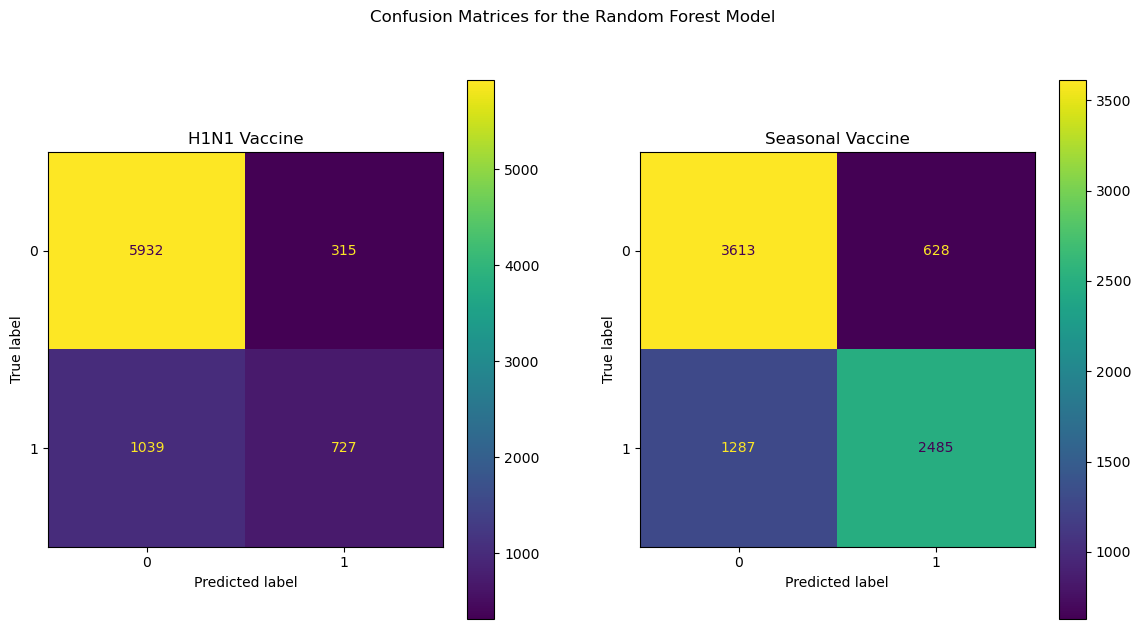

In [346]:
# Confusion Matrix for Random Forest 
predictions = forest_grid.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for the Random Forest Model')
plt.show()

In [360]:
y_preds = forest_grid.predict_proba(X_test)
y_preds_both = pd.DataFrame({"h1n1_vaccine":y_preds[0][:, 1], "seasonal_vaccine":y_preds[1][:, 1]}, index=Y_test.index)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plt.suptitle(f"ROC_AUC Curve XGBClassifier")

plot_roc(Y_test['h1n1_vaccine'], y_preds_both['h1n1_vaccine'], 'h1n1_vaccine',ax=ax[0])
plot_roc(Y_test['seasonal_vaccine'], y_preds_both['seasonal_vaccine'], 'seasonal_vaccine',ax=ax[1])
fig.tight_layout()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Gradient boosted decision tree

In [354]:
from xgboost import XGBClassifier
chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif), 
                                      XGBClassifier(use_label_encoder=False, verbosity=0, n_jobs=1)))

xgb_pipe = make_pipeline(col_transformer, chain)

c:\Users\danie\anaconda3\envs\COMP4030\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [355]:
params = {
    'classifierchain__base_estimator__selectpercentile__percentile': [10, 50, 90],
    'classifierchain__base_estimator__xgbclassifier__n_estimators': [100, 200, 500],
    'classifierchain__base_estimator__xgbclassifier__max_depth': list(range(1, 6)),
    'classifierchain__base_estimator__xgbclassifier__learning_rate': [0.1, 0.2],
    'classifierchain__base_estimator__xgbclassifier__reg_lambda': [0.1, 0.2, 0.3],
    'classifierchain__order': [[0, 1], [1, 0]]
}

xgb_grid = RandomizedSearchCV(xgb_pipe, params, scoring='roc_auc', n_iter=270, verbose=1, n_jobs=4)

xgb_grid.fit(X_train, Y_train.astype(int))

c:\Users\danie\anaconda3\envs\COMP4030\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 5 folds for each of 270 candidates, totalling 1350 fits


c:\Users\danie\anaconda3\envs\COMP4030\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_touch_face',
                                                                                'doctor_recc_h1n1',
                                                                                'doctor_recc_seasonal...
                                        'classifierchain__base_estimator__xgbclassifier__learning_rate': [0.1,
                                                                                                          0.2],
                                        'classifierchain__base_estimator__xgbclassifier__max_depth': [1,
                                                                                                      2,
                                                                                                      3,
                                                                                                      4,
                                                                                                      5],
                                        'classifierchain__base_estimator__xgbclassifier__n_estimators': [100,
                                                                                                         200,
                                                                                                         500],
                                        'classifierchain__base_estimator__xgbclassifier__reg_lambda': [0.1,
                                                                                                       0.2,
                                                                                                       0.3],
                                        'classifierchain__order': [[0, 1],
                                                                   [1, 0]]},
                   scoring='roc_auc', verbose=1)

In [356]:
# Best parameters for the model
display(xgb_grid.best_params_)

{'classifierchain__order': [0, 1],
 'classifierchain__base_estimator__xgbclassifier__reg_lambda': 0.1,
 'classifierchain__base_estimator__xgbclassifier__n_estimators': 100,
 'classifierchain__base_estimator__xgbclassifier__max_depth': 4,
 'classifierchain__base_estimator__xgbclassifier__learning_rate': 0.1,
 'classifierchain__base_estimator__selectpercentile__percentile': 90}

In [357]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(xgb_grid.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(xgb_grid.score(X_test, Y_test)))

Best model in-sample score: 0.8690
Best model out-of-sample score: 0.8450


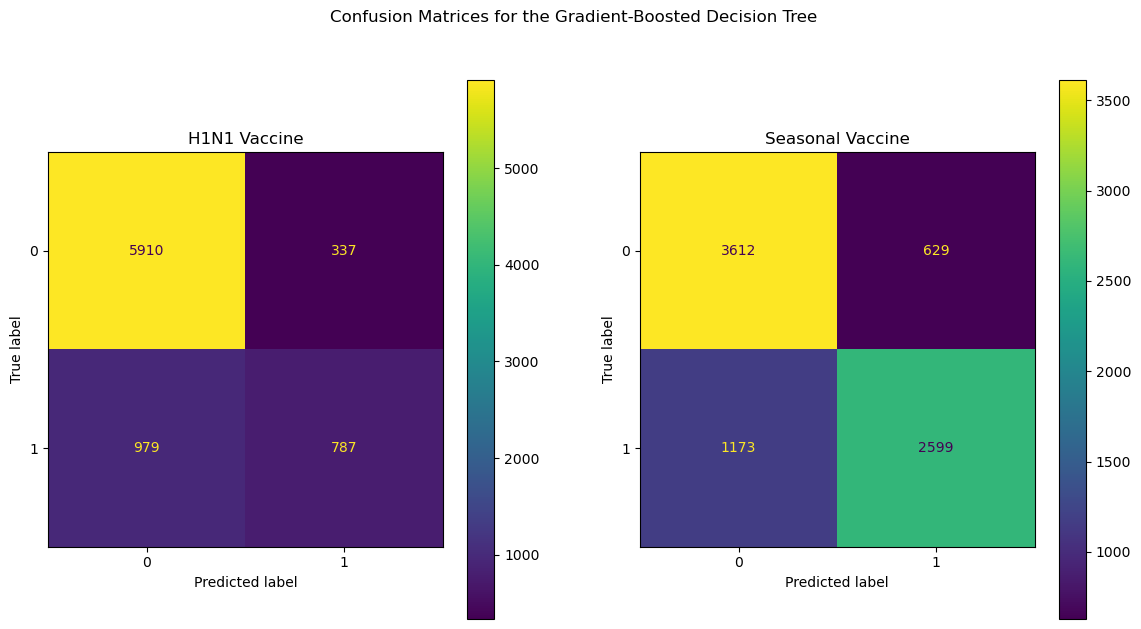

In [358]:
# Display confusion matrices for the model

from sklearn.metrics import ConfusionMatrixDisplay

predictions = xgb_grid.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for the Gradient-Boosted Decision Tree')
plt.show()

We convert all columns with a float dtype into an integer as they all do not lose any value after the decimal, alongside encoding all categorical data into a numeric form.

In [99]:
"""
enc = LabelEncoder()
features[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']] = data[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']].apply(enc.fit_transform)

features[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']]
"""

"\nenc = LabelEncoder()\nfeatures[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']] = data[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']].apply(enc.fit_transform)\n\nfeatures[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']]\n"

In [166]:
features.isnull().sum()/len(features)*100

h1n1_concern                    0.344479
h1n1_knowledge                  0.434343
behavioral_antiviral_meds       0.265848
behavioral_avoidance            0.778822
behavioral_face_mask            0.071142
behavioral_wash_hands           0.157262
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_touch_face           0.479275
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
opinion_h1n1_sick_from_vacc     1.479013
opinion_seas_vacc_effective     1.729884
opinion_seas_risk               1.924589
opinion_seas_sick_from_vacc     2.010709
age_group                       0.000000
education                       5.268282
race                            0.000000
sex                             0.000000
income_poverty  

In [350]:
#Assigned the columns with categorical data to a variable
categorical_data = ['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']

In [28]:
#Imputing the categorical data with the mode of each column
for column in categorical_data:
    features[column].fillna(features[column].mode()[0], inplace=True)

In [158]:
features.isnull().sum()/len(features)*100

h1n1_concern                    0.344479
h1n1_knowledge                  0.434343
behavioral_antiviral_meds       0.265848
behavioral_avoidance            0.778822
behavioral_face_mask            0.071142
behavioral_wash_hands           0.157262
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_touch_face           0.479275
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
opinion_h1n1_sick_from_vacc     1.479013
opinion_seas_vacc_effective     1.729884
opinion_seas_risk               1.924589
opinion_seas_sick_from_vacc     2.010709
age_group                       0.000000
education                       5.268282
race                            0.000000
sex                             0.000000
income_poverty  

In [30]:
features["health_insurance"].mean()

0.9349983150484892

In [455]:
def balance(features):
    from collections import Counter
    from numpy import log
    
    n = len(data)
    classes = [(clas,float(count)) for clas,count in Counter(data).items()]
    k = len(classes)
    
    H = -sum([ (count/n) * log((count/n)) for clas,count in classes]) #shannon entropy
    return H/log(k)

### Checking if the dataset is balanced

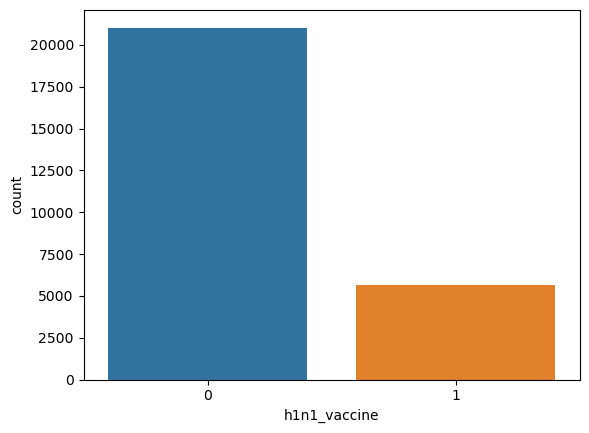

In [459]:
sns.countplot(x="h1n1_vaccine", data=labels);

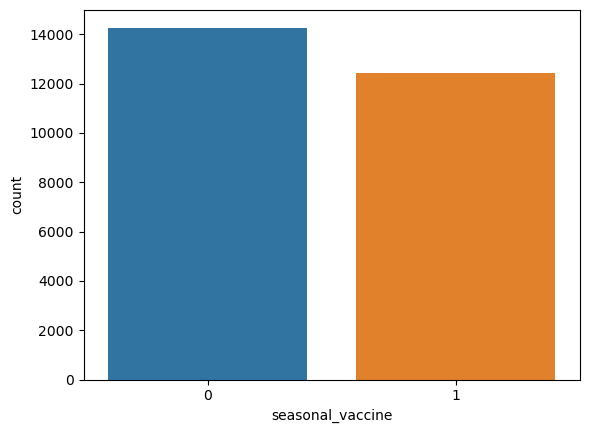

In [460]:
sns.countplot(x="seasonal_vaccine", data=labels);

### Dealing with outliers

C:\Users\danie\AppData\Local\Temp\ipykernel_6952\1794321463.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<AxesSubplot: >

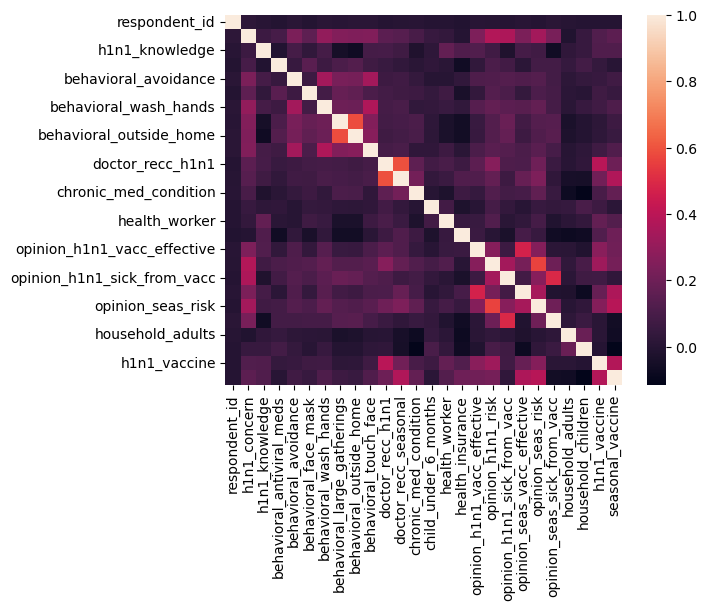

In [461]:
sns.heatmap(data.corr())

In [462]:
def findoutliers(column):
    outliers=[]
    Q1=column.quantile(.25)
    Q3=column.quantile(.75)
    IQR=Q3-Q1
    lower_limit=Q1-(1.5*IQR)
    upper_limit=Q3+(1.5*IQR)
    for out1 in column:
        if out1>upper_limit or out1 <lower_limit:
            outliers.append(out1)
            
    return np.array(outliers)  

In [463]:
sns.boxplot(features.household_children)

AttributeError: 'DataFrame' object has no attribute 'household_children'

<AxesSubplot: >

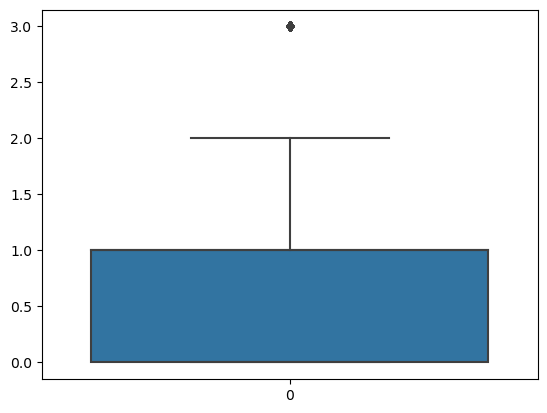

In [ ]:
sns.boxplot(features.household_adults)

In [ ]:
features.astype('int')

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children
0,1,0,0,0,0,0,0,1,1,0,...,1,3,0,2,1,0,1,2,0,0
1,3,2,0,1,0,1,0,1,1,0,...,0,3,1,2,1,1,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,...,2,3,1,0,1,0,0,0,2,0
3,1,1,0,1,0,1,1,0,0,0,...,0,3,0,2,1,1,1,1,0,0
4,2,1,0,1,0,1,1,0,1,0,...,3,3,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2,0,0,1,0,0,0,1,0,0,...,3,3,0,0,1,0,1,2,0,0
26703,1,2,0,1,0,1,0,0,0,1,...,2,3,1,0,1,1,0,1,1,0
26704,2,2,0,1,1,1,1,0,1,0,...,3,3,0,3,1,0,3,0,0,0
26705,1,1,0,0,0,0,0,0,1,0,...,3,1,0,0,0,1,0,2,1,0


### Plotting Standard Deviation

In [ ]:
features.std()

h1n1_concern                   0.909016
h1n1_knowledge                 0.617047
behavioral_antiviral_meds      0.215273
behavioral_avoidance           0.445127
behavioral_face_mask           0.253345
behavioral_wash_hands          0.379213
behavioral_large_gatherings    0.479264
behavioral_outside_home        0.472444
behavioral_touch_face          0.466942
doctor_recc_h1n1               0.401866
doctor_recc_seasonal           0.459592
chronic_med_condition          0.445490
child_under_6_months           0.271382
health_worker                  0.311077
opinion_h1n1_vacc_effective    1.000195
opinion_h1n1_risk              1.276825
opinion_h1n1_sick_from_vacc    1.353339
opinion_seas_vacc_effective    1.077131
opinion_seas_risk              1.375216
opinion_seas_sick_from_vacc    1.319585
age_group                      1.457320
education                      1.186442
race                           0.923226
sex                            0.491136
income_poverty                 1.113444


In [ ]:
std = labels['h1n1_vaccine'].std()
avg = labels['h1n1_vaccine'].std()

In [ ]:
avg + std #1std above the mean

0.8181035868580915

In [ ]:
avg-std #1std below the mean

0.0

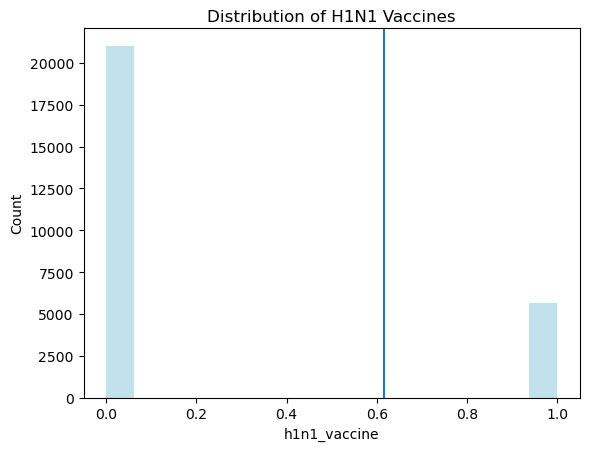

In [ ]:
sns.histplot(x = labels['h1n1_vaccine'], color = 'lightblue', edgecolor = None )
plt.title("Distribution of H1N1 Vaccines", pad=5)

plt.axvline(x = 0.616261209611533, ymin = 0, ymax = labels["h1n1_vaccine"].max())

Standard distribution of H1N1 vaccines using a quantile range

We will analyse which features may assist in the prediction of vaccination decision. 
We will begin by evaluating all the behavioural related variables below: 

- behavioral_antiviral_meds      
- behavioral_avoidance           
- behavioral_face_mask           
- behavioral_wash_hands          
- behavioral_large_gatherings    
- behavioral_outside_home        
- behavioral_touch_face

The data is binary.

# Cross Tabulation

In [ ]:
def crosstab(x, y):

    return pd.crosstab(x, y, normalize='columns')*100

In [ ]:
crosstab(labels['h1n1_vaccine'], features['behavioral_antiviral_meds'])

behavioral_antiviral_meds,0.0,1.0
h1n1_vaccine,,
0,79.126978,71.483474
1,20.873022,28.516526


In [ ]:
crosstab(labels['h1n1_vaccine'], features['behavioral_avoidance'])

behavioral_avoidance,0.0,1.0
h1n1_vaccine,,
0,81.886948,77.582836
1,18.113052,22.417164


In [ ]:
crosstab(labels['h1n1_vaccine'], features['behavioral_face_mask'])

behavioral_face_mask,0.0,1.0
h1n1_vaccine,,
0,79.538325,68.169473
1,20.461675,31.830527


In [ ]:
crosstab(labels['h1n1_vaccine'], features['behavioral_wash_hands'])

behavioral_wash_hands,0.0,1.0
h1n1_vaccine,,
0,85.397849,77.354128
1,14.602151,22.645872


In [ ]:
crosstab(labels['h1n1_vaccine'], features['behavioral_large_gatherings'])

behavioral_large_gatherings,0.0,1.0
h1n1_vaccine,,
0,79.306527,77.762648
1,20.693473,22.237352


In [ ]:
crosstab(labels['h1n1_vaccine'], features['behavioral_outside_home'])

behavioral_outside_home,0.0,1.0
h1n1_vaccine,,
0,79.397495,77.485803
1,20.602505,22.514197


In [ ]:
crosstab(labels['h1n1_vaccine'], features['behavioral_touch_face'])

behavioral_touch_face,0.0,1.0
h1n1_vaccine,,
0,82.968058,76.760991
1,17.031942,23.239009


We can see that from all behavioral based variables, there is a slight uptrend of positive actions leading to people taking the vaccine.

### Visualisation

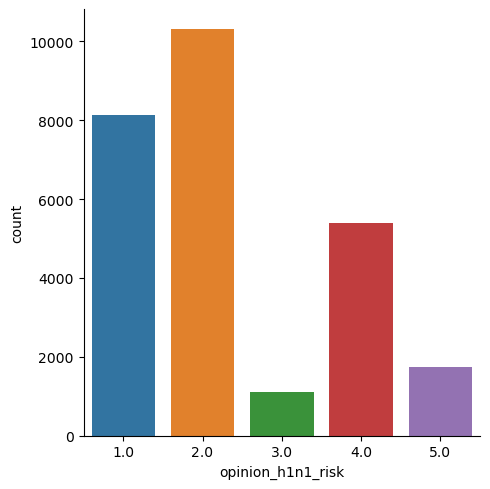

In [ ]:
sns.catplot(data = features, x = "opinion_h1n1_risk", kind = "count")

Most people are not worried about the H1N1 vaccine

## Feature Scaling

In [464]:
X = features
y = labels

In [465]:
X = StandardScaler().fit_transform(X)

## Feature Selection

### Applying PCA

In [466]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

## Creating the models

In [467]:
X

array([[-0.37521796,  1.5085512 , -0.80964769, ..., -0.34658204,
        -0.26455999, -0.09701104],
       [-0.37521796, -0.66288768, -0.80964769, ..., -0.34658204,
        -0.26455999, -0.09701104],
       [-0.37521796,  1.5085512 , -0.80964769, ..., -0.34658204,
        -0.26455999, -0.09701104],
       ...,
       [-0.37521796, -0.66288768,  1.23510511, ..., -0.34658204,
        -0.26455999, -0.09701104],
       [-0.37521796,  1.5085512 , -0.80964769, ..., -0.34658204,
        -0.26455999, -0.09701104],
       [ 2.66511762, -0.66288768, -0.80964769, ..., -0.34658204,
        -0.26455999, -0.09701104]])

In [468]:
features.head()

,h1n1_concern_0.0,h1n1_concern_1.0,h1n1_concern_2.0,h1n1_concern_3.0,h1n1_concern_nan,h1n1_knowledge_0.0,h1n1_knowledge_1.0,h1n1_knowledge_2.0,h1n1_knowledge_nan,behavioral_antiviral_meds_0.0,...,household_adults_0.0,household_adults_1.0,household_adults_2.0,household_adults_3.0,household_adults_nan,household_children_0.0,household_children_1.0,household_children_2.0,household_children_3.0,household_children_nan
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [469]:
y

,h1n1_vaccine,seasonal_vaccine
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1
26705,0,0


### Train/Test Split

In [470]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 30)

In [359]:
#Driven data function to evaluate model's performance
def plot_roc(y_true, y_score, label_name, ax, color=False):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    if color:
        ax.set_facecolor('lightblue')
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {metrics.roc_auc_score(y_true, y_score):.4f}"
    )

### Naive Bayes

In [472]:
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance

brmodel = BinaryRelevance(GaussianNB())

brmodel.fit(x_train, y_train)

y_prediction_nb = brmodel.predict(x_test)



In [473]:
accuracy_nb = accuracy_score(y_test, y_prediction_nb)
accuracy_nb

0.497079526733563

### Linear SVC using Multi Output Classifier

The MultiOutputClassifier is convenient since it simplifies the process and you can predict both labels in just one step. 
On the other hand predicting the two labels separately gives you more control and you may be able to fine tune the model for each case or even use two completely different models.

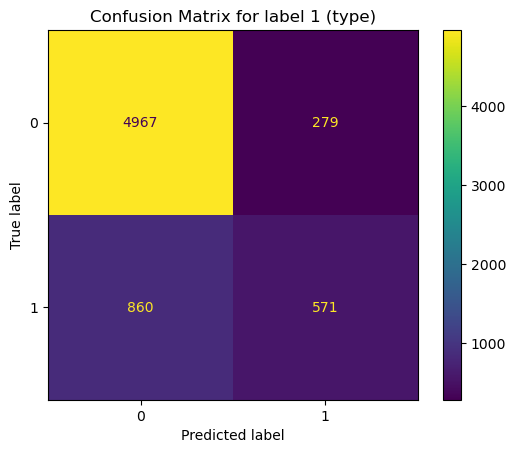

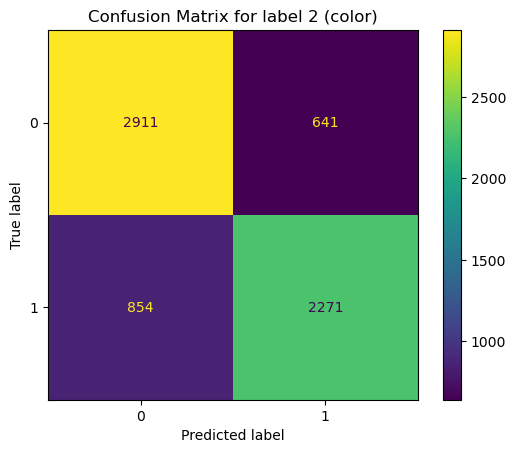

In [474]:

from sklearn.datasets import make_blobs
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Create the SVM
svm = LinearSVC(random_state=42)

# Make it an Multilabel classifier
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

# Get predictions for test data
y_test_pred = multilabel_classifier.predict(x_test)

# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(y_test, y_test_pred)

# Plotting matrices: code
cmd = ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 1 (type)')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 2 (color)')
plt.show()

In [475]:
accuracy_svc = accuracy_score(y_test, y_test_pred)
accuracy_svc

0.6655683690280065

### Random Forest 

In [476]:
random_forest = RandomForestClassifier()

In [477]:
random_forest.fit(x_train, y_train)

y_prediction_rf = random_forest.predict(x_test)

accuracy_rf = accuracy_score(y_test, y_prediction_rf)
accuracy_rf

0.6627227796914782

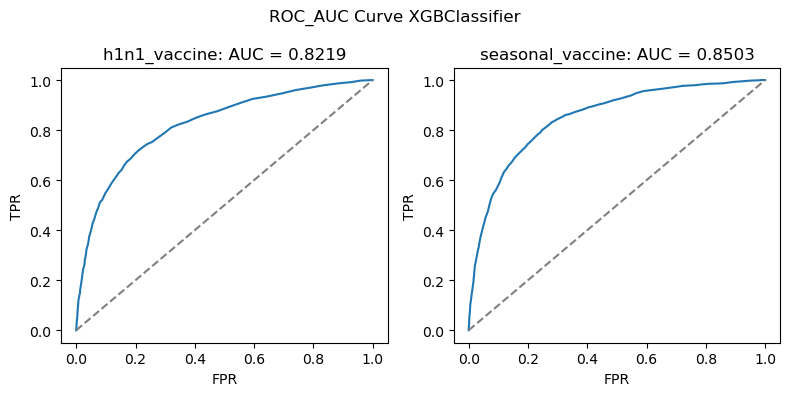

In [478]:
y_preds = random_forest.predict_proba(x_test)
y_preds_both = pd.DataFrame({"h1n1_vaccine":y_preds[0][:, 1], "seasonal_vaccine":y_preds[1][:, 1]}, index=y_test.index)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plt.suptitle(f"ROC_AUC Curve XGBClassifier")

plot_roc(y_test['h1n1_vaccine'], y_preds_both['h1n1_vaccine'], 'h1n1_vaccine',ax=ax[0])
plot_roc(y_test['seasonal_vaccine'], y_preds_both['seasonal_vaccine'], 'seasonal_vaccine',ax=ax[1])
fig.tight_layout()

In [479]:
metrics.roc_auc_score(y_test, y_preds_both)

0.8360860166363179

We use the support vector classicier with a linear kernel

### Multilabel K-Nearest Neighbour

### XGBoost Classifier

In [480]:
import xgboost as xgb

xgb_cl = MultiOutputClassifier(estimator=xgb.XGBClassifier(n_estimators=1000, verbosity=1, n_jobs=-1, learning_rate=0.05))
xgb_cl.fit(x_train, y_train)
preds = xgb_cl.predict(x_test)

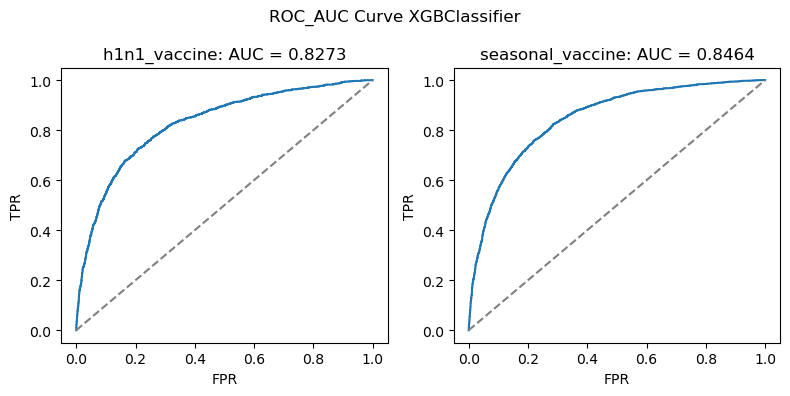

In [481]:
y_preds = xgb_cl.predict_proba(x_test)
y_preds_both = pd.DataFrame({"h1n1_vaccine":y_preds[0][:, 1], "seasonal_vaccine":y_preds[1][:, 1]}, index=y_test.index)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plt.suptitle(f"ROC_AUC Curve XGBClassifier")

plot_roc(y_test['h1n1_vaccine'], y_preds_both['h1n1_vaccine'], 'h1n1_vaccine',ax=ax[0])
plot_roc(y_test['seasonal_vaccine'], y_preds_both['seasonal_vaccine'], 'seasonal_vaccine',ax=ax[1])
fig.tight_layout()

In [482]:
metrics.roc_auc_score(y_test, y_preds_both)

0.8368786683051533

### TESTING OTHER MODELS

## Submission Dataframe

In [483]:
y_test_h1n1 = y_test.loc[:, ['h1n1_vaccine']]
y_test_seasonal = y_test.loc[:, ["seasonal_vaccine"]]

In [484]:
y_test_h1n1.shape

(6677, 1)

In [485]:
y_pred_h1n1 = y_preds_both.loc[:, 'h1n1_vaccine']
y_pred_seasonal = y_preds_both.loc[:, "seasonal_vaccine"]

In [486]:
target = ["Non-Vaccinated", "Vaccinated"]

H1N1 Vaccines

In [487]:
print(metrics.classification_report(y_test_h1n1.round(), y_pred_h1n1.round(), target_names = target))

                precision    recall  f1-score   support

Non-Vaccinated       0.86      0.94      0.90      5246
    Vaccinated       0.65      0.44      0.52      1431

      accuracy                           0.83      6677
     macro avg       0.75      0.69      0.71      6677
  weighted avg       0.81      0.83      0.82      6677



Seasonal Vaccines

In [488]:
print(metrics.classification_report(y_test_seasonal.round(), y_pred_seasonal.round(), target_names = target))

                precision    recall  f1-score   support

Non-Vaccinated       0.78      0.79      0.79      3552
    Vaccinated       0.76      0.74      0.75      3125

      accuracy                           0.77      6677
     macro avg       0.77      0.77      0.77      6677
  weighted avg       0.77      0.77      0.77      6677



## Submission File

Pre-processing of testing features dataframe

In [374]:
def testing_preprocessing():

    test_features_df = pd.read_csv("test_set_features.csv", index_col="respondent_id")
    test_features_df.tail()
    test_features_df.drop(["health_insurance", "employment_industry", "employment_occupation"], axis = 1, inplace = True)

    numeric_data = test_features_df._get_numeric_data()

    for column in numeric_data:
        test_features_df[column].fillna(test_features_df[column].median(), inplace= True)
        
    #for column in categorical_data:
        #test_features_df[column].fillna(test_features_df[column].mode()[0], inplace=True)

    #test_features_df[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']] = test_features_df[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']].apply(enc.fit_transform)

    #test_features_df[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','census_msa']]

    return test_features_df

In [375]:
test_df = testing_preprocessing()

In [378]:
best_model = forest_grid.best_estimator_
best_model.fit(features, labels)

comp_predictions = pd.DataFrame(best_model.predict_proba(test_df), index=test_df.index, columns=labels.columns)

comp_predictions.to_csv('random_forest.csv')

In [379]:
comp_predictions.head(10)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.158242,0.230870
26708,0.046331,0.053460
26709,0.448044,0.688296
26710,0.546301,0.949504
26711,0.311588,0.433715
26712,0.558337,0.958190
26713,0.366528,0.405621
26714,0.126041,0.150715
26715,0.047859,0.135575


In [377]:
test_df.tail()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,White,Female,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0
53413,3.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",1.0,0.0
53414,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,White,Female,NaN,Not Married,Rent,Employed,lrircsnp,"MSA, Principle City",0.0,0.0


In [ ]:
test_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children
0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,2,1,0,1,1,1,0,0,1.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,3,1,2,1,1,0,2,3.0,0.0
2,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,2,3,1,1,0,0,0,2,1.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,3,0,0,0,0,1,0,1.0,0.0
4,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,1,0,0,2,0.0,1.0


In [ ]:
scaler = MinMaxScaler()
test_df = scaler.fit_transform(test_df)

In [ ]:
test_probs = regressor.predict(test_df)
test_probs

NameError: name 'regressor' is not defined

In [ ]:
submission_df = pd.read_csv("submission_format.csv", index_col="respondent_id")

In [ ]:
submission_df.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.5,0.7
1,26708,0.5,0.7
2,26709,0.5,0.7
3,26710,0.5,0.7
4,26711,0.5,0.7


In [ ]:
submission_df["h1n1_vaccine"] = test_probs[0][:, 1]
submission_df["seasonal_vaccine"] = test_probs[1][:, 1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
submission_df.to_csv('my_submission.csv', index=True)
submission_df.head(10)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7
26712,0.5,0.7
26713,0.5,0.7
26714,0.5,0.7
26715,0.5,0.7
